In [1]:
import pandas as pd
from PIL import Image
import seaborn as sns
import numpy as np
import copy
import os
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import torchmetrics

In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
meta = pd.read_csv('imagewoof2/noisy_imagewoof.csv')
lbl_dict = {
      'n02086240':'Shih-Tzu',
      'n02087394':'Rhodesian ridgeback',
      'n02088364':'Beagle',
      'n02089973':'English foxhound',
      'n02093754':'Australian terrier',
      'n02096294':'Border terrier',
      'n02099601':'Golden retriever',
      'n02105641':'Old English sheepdog',
      'n02111889':'Samoyed',
      'n02115641':'Dingo'
    }

mapper = {   
      '0': 'Shih-Tzu',
      '1': 'Rhodesian ridgeback',
      '2': 'Beagle',
      '3': 'English foxhound',
      '4': 'Australian terrier',
      '5': 'Border terrier',
      '6': 'Golden retriever',
      '7': 'Old English sheepdog',
      '8': 'Samoyed',
      '9': 'Dingo'
    }

In [ ]:
def process_meta(meta: pd.DataFrame):
    
    meta['path'] = 'imagewoof2/' + meta['path']
    meta['label'] = meta['noisy_labels_0'].astype('category').cat.codes

    for i in meta['path']:
        assert os.path.exists(i)
    return meta[['path', 'label','is_valid']]

In [ ]:
meta = process_meta(meta)
val_percent = np.round(len(meta[meta['is_valid']==True]) / len(meta), 2)
print('TRAIN:', 1 - val_percent)
print('VALID:', val_percent)

TRAIN: 0.7
VALID: 0.3


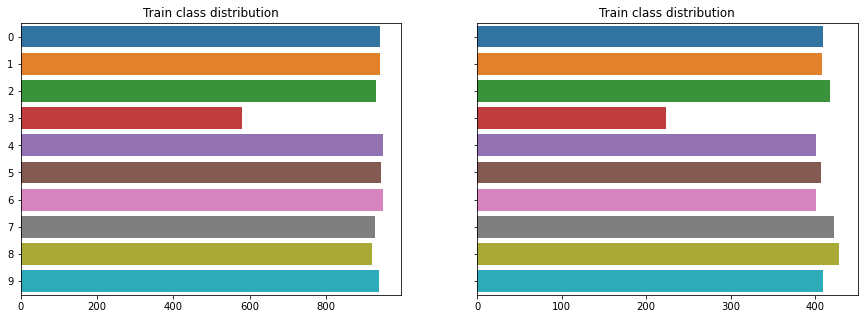

In [ ]:
dist_train = dict(meta[meta['is_valid'] == False]['label'].value_counts())
dist_val = dict(meta[meta['is_valid'] == True]['label'].value_counts())

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.barplot(
    ax=axes[0], 
    y=list(dist_train.keys()), 
    x=list(dist_train.values()), orient='h'
).set_title('Train class distribution')

sns.barplot(
    ax=axes[1], 
    y=list(dist_val.keys()), 
    x=list(dist_val.values()), orient='h'
).set_title('Train class distribution')
plt.show()

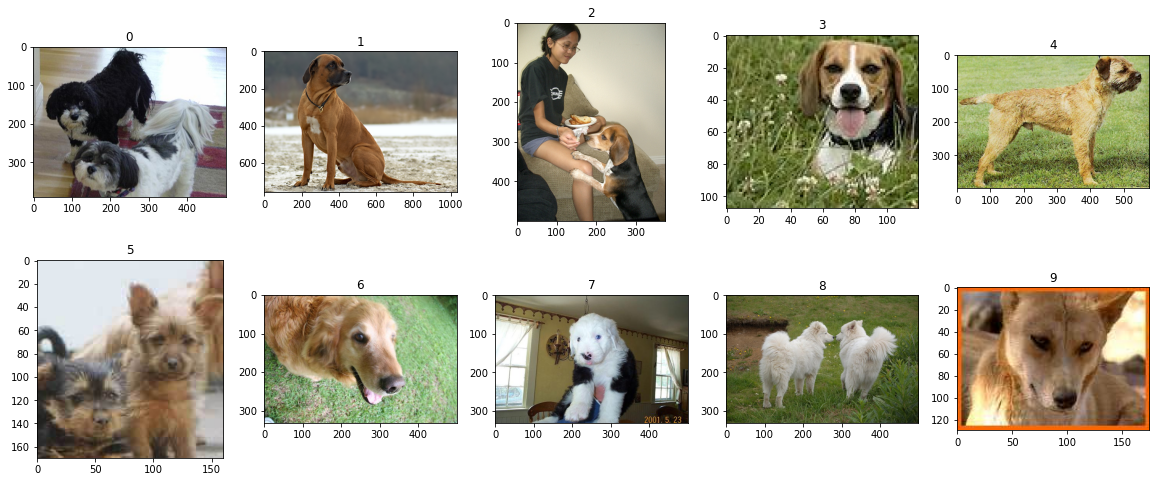

In [ ]:
fig = plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i, (name, df) in enumerate(meta.groupby('label')):
    fig.add_subplot(rows, columns, i+1)
    plt.title(name)
    img = mpimg.imread(df['path'].values[np.random.randint(0, len(df['path']))])
    plt.imshow(img)
plt.show()

In [ ]:
class WoofDataset(Dataset):
    
    def __init__(self, meta: pd.DataFrame, transforms=None):
        self.meta = meta.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, i):
        image = np.array(Image.open(self.meta['path'][i]).convert('RGB'))
        label = int(self.meta['label'][i])
        # TODO: Refactor this
        if self.transforms:
            image = self.transforms(image=image)['image']
            return {'image':image, 'label':torch.tensor([label])}
        else:
            return {'image':image, 'label':torch.tensor([label])}
    

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train = meta[meta['is_valid'] == False]
test = meta[meta['is_valid'] == True]
trainset = WoofDataset(train, train_transform)
testset = WoofDataset(test, test_transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=64)

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b3')

# Freeze weights
for param in model.parameters():
    param.requires_grad = False
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, 10)


Loaded pretrained weights for efficientnet-b3


In [ ]:
model(torch.rand(1, 3, 512, 512))

tensor([[ 0.0177,  0.0901, -0.1758, -0.0606,  0.0618,  0.0681,  0.1059,  0.0158,
          0.0113, -0.0152]], grad_fn=<AddmmBackward0>)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=3e-4,
)
device = torch.device('cuda:2')
model.to(device)
acc = torchmetrics.Accuracy().to(device)
prs = torchmetrics.Precision(average='none', num_classes=10).to(device)
rcl = torchmetrics.Recall(average='none', num_classes=10).to(device)

In [ ]:
for i in range(30):
    print('epoch', i+1)
    model.train()
    epoch_loss = 0
    for batch in trainloader:
        optimizer.zero_grad()
        batch['label'] = batch['label'].squeeze(1).to(device)
        y_hat = model(batch['image'].to(device))

        loss = criterion(y_hat, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    print('loss_on_train', epoch_loss/len(trainloader))
    model.eval()
    for batch in testloader:
        batch['label'] = batch['label'].squeeze(1).to(device)
        y_hat = model(batch['image'].to(device))

        acc.update(y_hat, batch['label'])
        prs.update(y_hat, batch['label'])
        rcl.update(y_hat, batch['label'])
    print('accuracy on test', acc.compute())
    print('precision on test', prs.compute())
    print('recall on test', rcl.compute())
    torch.save(model.state_dict(), 'weights.pth')

epoch 1
loss_on_train 1.2781511578880014
accuracy on test tensor(0.9270, device='cuda:2')
precision on test tensor([0.9177, 0.9062, 0.8661, 0.8670, 0.9082, 0.9570, 0.9543, 0.9461, 0.9633,
        0.9600], device='cuda:2')
recall on test tensor([0.9267, 0.9706, 0.9282, 0.7277, 0.9377, 0.8747, 0.9377, 0.9573, 0.9790,
        0.9366], device='cuda:2')
epoch 2
loss_on_train 0.6622438410777507
accuracy on test tensor(0.9230, device='cuda:2')
precision on test tensor([0.9127, 0.9057, 0.8587, 0.8472, 0.9132, 0.9517, 0.9470, 0.9415, 0.9598,
        0.9611], device='cuda:2')
recall on test tensor([0.9205, 0.9657, 0.9234, 0.7299, 0.9314, 0.8722, 0.9352, 0.9538, 0.9744,
        0.9329], device='cuda:2')
epoch 3
loss_on_train 0.5327052709913085
accuracy on test tensor(0.9230, device='cuda:2')
precision on test tensor([0.9121, 0.9104, 0.8618, 0.8441, 0.9092, 0.9492, 0.9446, 0.9465, 0.9565,
        0.9615], device='cuda:2')
recall on test tensor([0.9218, 0.9624, 0.9203, 0.7411, 0.9318, 0.8714, 0.936

In [ ]:
model.cpu()
model.load_state_dict(torch.load('weights.pth', map_location=torch.device('cpu')))
def inference(image: Image, model):

    model.eval()
    x = np.array(image.convert('RGB'))
    x_processed = test_transform(image=x)['image']
    y_hat = model(x_processed.unsqueeze(0))
    preds = y_hat.argmax(dim=1).item()
    return mapper[str(preds)]

In [ ]:
img = Image.open(r'C:\Users\avkos\Desktop\idp_flask\uploads\foxhound.jpg')
inference(img, model)

'English foxhound'